In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np


In [14]:
file_path = 'almonds/Almond.csv'
almond_data = pd.read_csv(file_path)

almond_data.info(), print(almond_data.head())

almond_data_cleaned = almond_data.drop(columns=['Unnamed: 0'])

features = almond_data_cleaned.drop(columns=['Type'])
target = almond_data_cleaned['Type']

scaler = MinMaxScaler()
features_normalized = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

features_normalized_filled = features_normalized.fillna(-1)

encoder = OneHotEncoder(sparse=False)
target_encoded_filled = pd.DataFrame(encoder.fit_transform(target.values.reshape(-1, 1)), columns=encoder.categories_[0])

preprocessed_data_filled = pd.concat([features_normalized_filled, target_encoded_filled], axis=1)

for index, row in preprocessed_data_filled.iterrows():
        for col in preprocessed_data_filled.columns:
            value = row[col]
            if not (0 <= value <= 1 or value == -1):
                print(f"Invalid value found: {value} at row {index}, column '{col}'")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2803 entries, 0 to 2802
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                2803 non-null   int64  
 1   Length (major axis)       1946 non-null   float64
 2   Width (minor axis)        1861 non-null   float64
 3   Thickness (depth)         1799 non-null   float64
 4   Area                      2803 non-null   float64
 5   Perimeter                 2803 non-null   float64
 6   Roundness                 1946 non-null   float64
 7   Solidity                  2803 non-null   float64
 8   Compactness               2803 non-null   float64
 9   Aspect Ratio              1004 non-null   float64
 10  Eccentricity              1004 non-null   float64
 11  Extent                    2803 non-null   float64
 12  Convex hull(convex area)  2803 non-null   float64
 13  Type                      2803 non-null   object 
dtypes: float

In [15]:

output_file_path = 'almonds/Almond_Prepped.csv'
preprocessed_data_filled.to_csv(output_file_path, index=False)

In [7]:
Prepped_file_path = 'almonds/Almond_Prepped.csv'
preprocessed_data_filled = pd.read_csv(Prepped_file_path)
print(preprocessed_data_filled.sample(10))


      Length (major axis)  Width (minor axis)  Thickness (depth)      Area  \
672              0.413279            0.511833          -1.000000  0.426110   
707             -1.000000            0.676547           0.558901  0.155589   
2629             0.639755           -1.000000           0.660698  0.420740   
1796            -1.000000            0.256159           0.214268  0.033443   
186             -1.000000            0.645863           0.979443  0.256448   
2397             0.198832            0.333063          -1.000000  0.225107   
1740             0.371040            0.518918          -1.000000  0.396600   
2461            -1.000000            0.401112           0.348081  0.078023   
1985             0.400359           -1.000000           0.652527  0.308103   
1530             0.254755           -1.000000           0.172700  0.091837   

      Perimeter  Roundness  Solidity  Compactness  Aspect Ratio  Eccentricity  \
672    0.334682   0.776602  0.977123     0.018936      0.241

In [8]:
X = preprocessed_data_filled.drop(columns=['MAMRA', 'REGULAR', 'SANORA']).values
Y = preprocessed_data_filled[['MAMRA', 'REGULAR', 'SANORA']].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_eval, Y_train, Y_eval = train_test_split(X_train, Y_train, test_size=0.375, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)
Y_eval_tensor = torch.tensor(Y_eval, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
eval_dataset = TensorDataset(X_eval_tensor, Y_eval_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, actFunc = 'ReLU'):
        super(NN, self).__init__()
        self.inputLayer = nn.Linear(input_size, hidden_layers[0])
        self.hiddenLayers = []
        for i in range(len(hidden_layers)-1):
            self.hiddenLayers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
        self.outputLayer = nn.Linear(hidden_layers[-1], output_size)
        self.actFunc = nn.ReLU()
        if (actFunc == 'Sigmoid'):
            self.actFunc = nn.Sigmoid()
        if (actFunc == 'TanH'):
            self.actFunc = nn.Tanh()
        if (actFunc == 'SoftPlus'):
            self.actFunc = nn.Softplus()
        if (actFunc == 'SiLU'):
            self.actFunc = nn.SiLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.actFunc(self.inputLayer(x))
        for layer in self.hiddenLayers:
            x = self.actFunc(layer(x))
        x = self.softmax(self.outputLayer(x))
        return x

In [10]:

def train_model(optimizer, model, loader, eval_loader, num_epochs, verbose = 1):
    Train_loss = []
    Train_Acc = []
    Test_loss = []
    Test_Acc = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for inputs, labels in loader:
            outputs = model(inputs)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(outputs, torch.max(labels, 1)[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == torch.max(labels, 1)[1]).sum().item()
            total_samples += labels.size(0)
        l, a = test_model(model, eval_loader, verbose)
        Test_Acc.append(a)
        Test_loss.append(l)
        epoch_loss = running_loss / len(loader)
        epoch_accuracy = correct_predictions / total_samples * 100
        Train_Acc.append(epoch_accuracy)
        Train_loss.append(epoch_loss)
        
        if (verbose == 1 or verbose == 2):
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    return Train_loss, Train_Acc, Test_loss, Test_Acc

def test_model(model, loader, verbose = 1):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(outputs, torch.max(labels, 1)[1])
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            labels_class = torch.max(labels, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels_class).sum().item()
    accuracy = 100 * (correct / total)
    epoch_loss = running_loss / len(loader)
    if(verbose == 1):
        print(f'Test Accuracy: {accuracy:.2f}%')
        print(f'Test Loss: {epoch_loss:.2f}')
    return loss, accuracy

In [11]:
def simulate(hiddenLayers, activationFunction, train_loader, eval_loader, epochs = 100, verbose = 0):
    input_size = 12
    output_size = 3

    hidden_size = [4]
    for _ in range(hiddenLayers - 1):
        next_number = hidden_size[0] * 2
        hidden_size.insert(0, next_number)
    
    learning_rate = 0.001
    model = NN(input_size, hidden_size, output_size, activationFunction)
    optimizer_adam = optim.Adam(model.parameters(), lr=learning_rate)

    Train_loss, Train_Acc, Test_loss, Test_Acc = train_model(optimizer_adam, model, train_loader, eval_loader, epochs, verbose)

    return model, Train_loss, Train_Acc, Test_loss, Test_Acc


Activation Functiom:ReLU
Number of hidden Layers: 1
5
Test Accuracy: 61.50%
Test Loss: 0.92
4
Test Accuracy: 62.39%
Test Loss: 0.91
3
Test Accuracy: 62.57%
Test Loss: 0.91
2
Test Accuracy: 68.09%
Test Loss: 0.88
1
Test Accuracy: 64.88%
Test Loss: 0.89


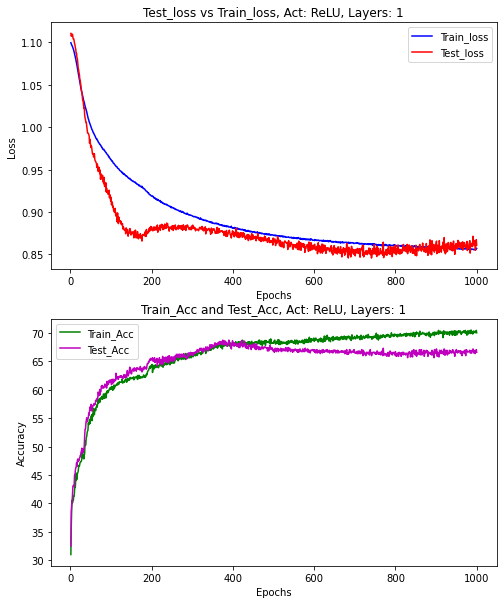

Activation Functiom:Sigmoid
Number of hidden Layers: 1
5
Test Accuracy: 63.64%
Test Loss: 0.91
4
Test Accuracy: 64.71%
Test Loss: 0.91
3
Test Accuracy: 63.46%
Test Loss: 0.91
2
Test Accuracy: 63.99%
Test Loss: 0.91
1
Test Accuracy: 63.10%
Test Loss: 0.91


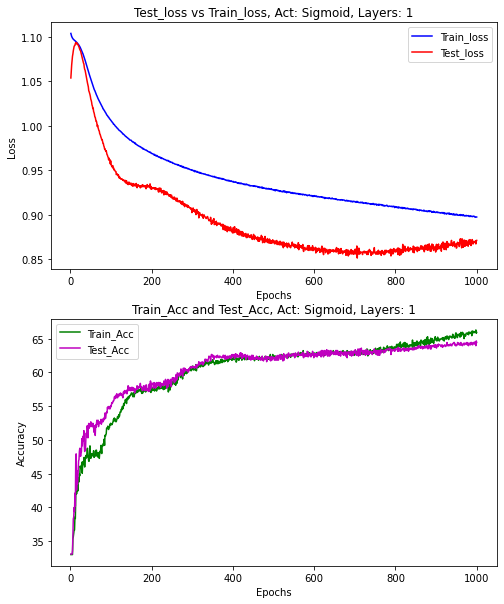

Activation Functiom:TanH
Number of hidden Layers: 1
5
Test Accuracy: 65.60%
Test Loss: 0.89
4
Test Accuracy: 64.88%
Test Loss: 0.89
3
Test Accuracy: 64.71%
Test Loss: 0.89
2
Test Accuracy: 65.24%
Test Loss: 0.89
1
Test Accuracy: 64.53%
Test Loss: 0.89


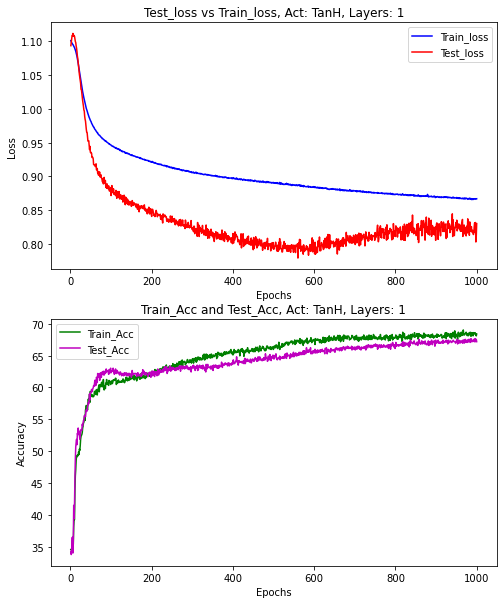

Activation Functiom:SoftPlus
Number of hidden Layers: 1
5
Test Accuracy: 62.75%
Test Loss: 0.91
4
Test Accuracy: 65.06%
Test Loss: 0.89
3
Test Accuracy: 64.35%
Test Loss: 0.89
2
Test Accuracy: 62.39%
Test Loss: 0.91
1
Test Accuracy: 63.10%
Test Loss: 0.91


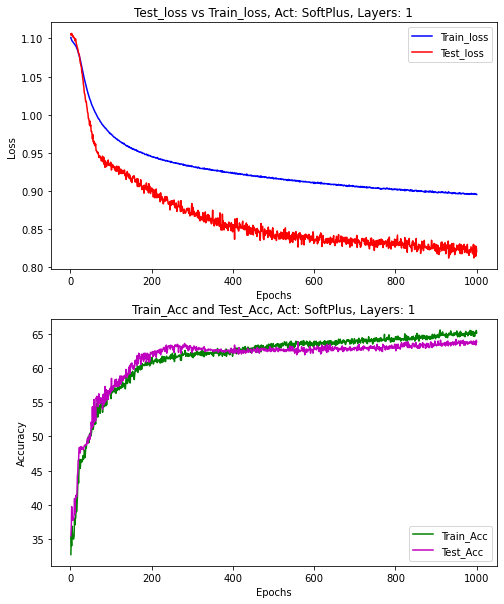

Activation Functiom:SiLU
Number of hidden Layers: 1
5
Test Accuracy: 65.06%
Test Loss: 0.89
4
Test Accuracy: 63.99%
Test Loss: 0.90
3
Test Accuracy: 65.24%
Test Loss: 0.89
2
Test Accuracy: 65.06%
Test Loss: 0.90
1
Test Accuracy: 62.39%
Test Loss: 0.90


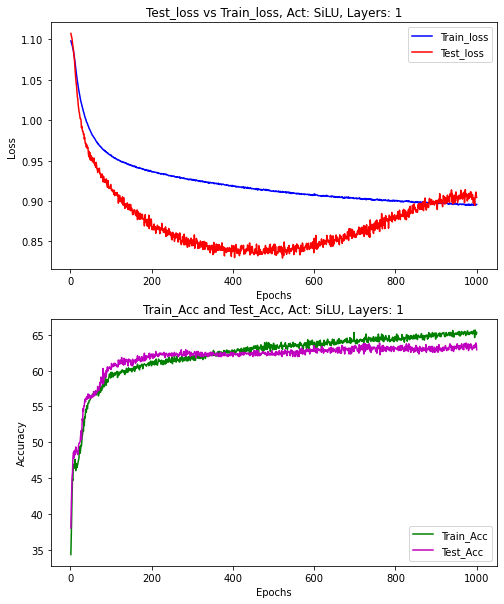

Activation Functiom:ReLU
Number of hidden Layers: 2
5
Test Accuracy: 64.88%
Test Loss: 0.89
4
Test Accuracy: 66.31%
Test Loss: 0.89
3
Test Accuracy: 64.71%
Test Loss: 0.90
2
Test Accuracy: 64.35%
Test Loss: 0.90
1
Test Accuracy: 64.71%
Test Loss: 0.89


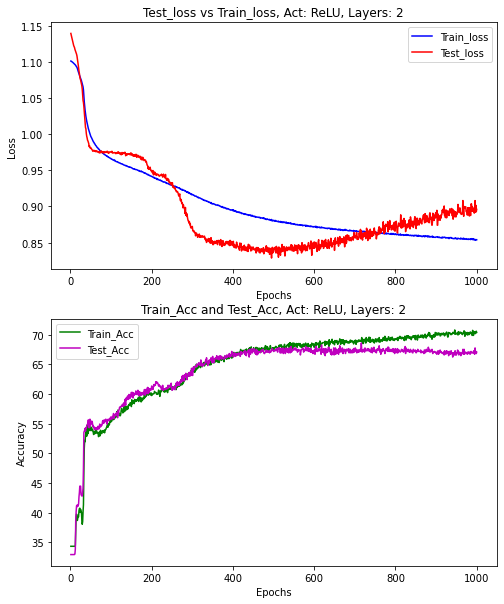

Activation Functiom:Sigmoid
Number of hidden Layers: 2
5
Test Accuracy: 58.29%
Test Loss: 0.96
4
Test Accuracy: 54.55%
Test Loss: 0.97
3
Test Accuracy: 62.21%
Test Loss: 0.97
2
Test Accuracy: 54.37%
Test Loss: 0.97
1
Test Accuracy: 55.97%
Test Loss: 0.96


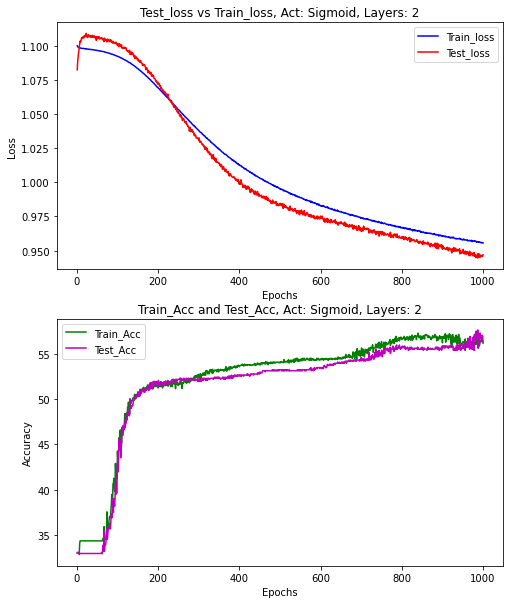

Activation Functiom:TanH
Number of hidden Layers: 2
5
Test Accuracy: 66.49%
Test Loss: 0.88
4
Test Accuracy: 65.60%
Test Loss: 0.89
3
Test Accuracy: 66.13%
Test Loss: 0.88
2
Test Accuracy: 66.67%
Test Loss: 0.88
1
Test Accuracy: 67.38%
Test Loss: 0.87


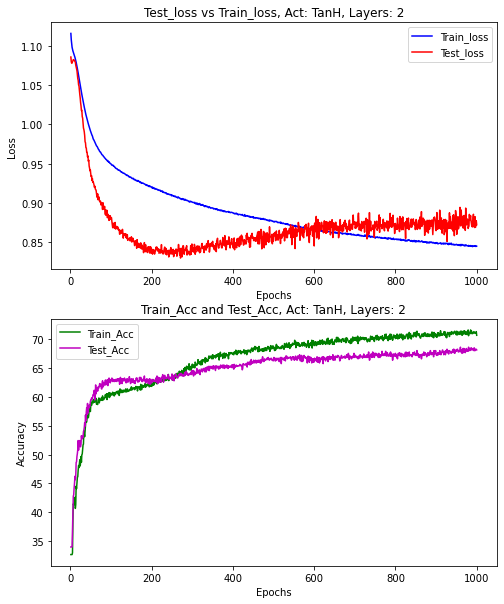

Activation Functiom:SoftPlus
Number of hidden Layers: 2
5
Test Accuracy: 63.64%
Test Loss: 0.90
4
Test Accuracy: 64.71%
Test Loss: 0.90
3
Test Accuracy: 63.28%
Test Loss: 0.90
2
Test Accuracy: 63.64%
Test Loss: 0.90
1
Test Accuracy: 65.24%
Test Loss: 0.90


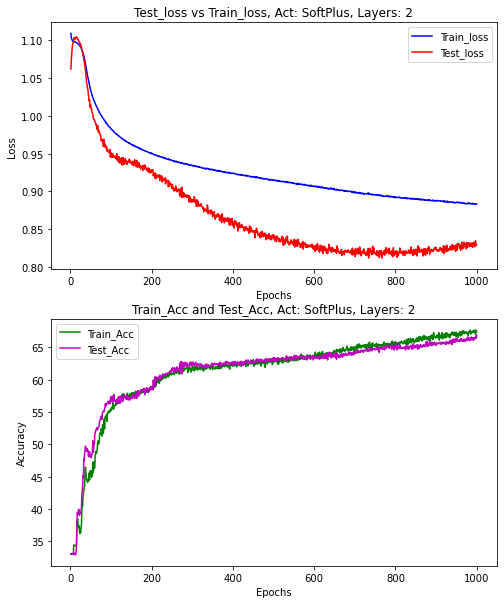

Activation Functiom:SiLU
Number of hidden Layers: 2
5
Test Accuracy: 65.42%
Test Loss: 0.89
4
Test Accuracy: 66.31%
Test Loss: 0.88
3
Test Accuracy: 65.06%
Test Loss: 0.89
2
Test Accuracy: 66.13%
Test Loss: 0.88
1
Test Accuracy: 65.06%
Test Loss: 0.89


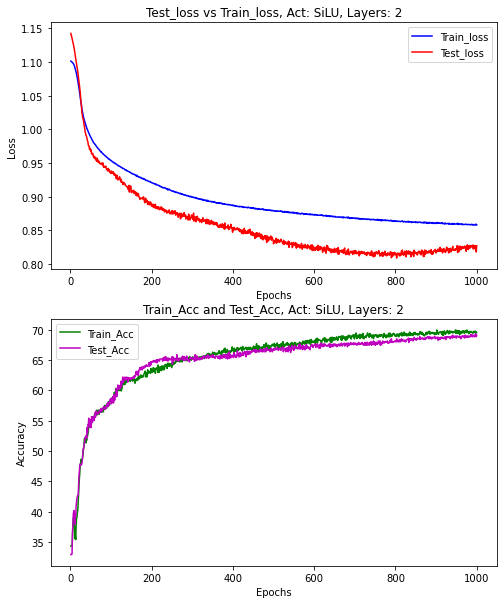

Activation Functiom:ReLU
Number of hidden Layers: 3
5
Test Accuracy: 67.56%
Test Loss: 0.88
4
Test Accuracy: 65.06%
Test Loss: 0.90
3
Test Accuracy: 61.50%
Test Loss: 0.90
2
Test Accuracy: 64.35%
Test Loss: 0.89
1
Test Accuracy: 66.49%
Test Loss: 0.88


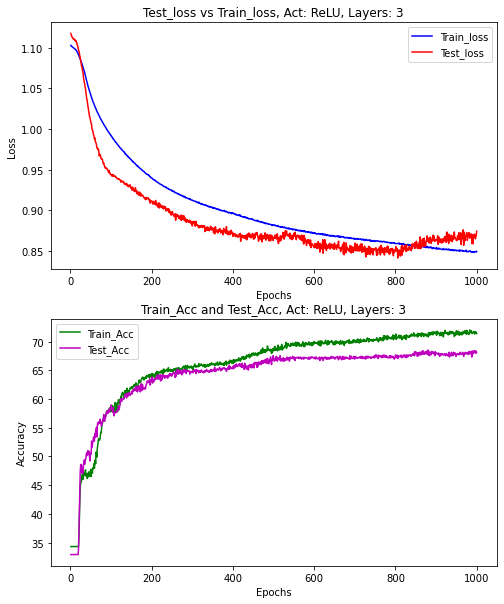

Activation Functiom:Sigmoid
Number of hidden Layers: 3
5
Test Accuracy: 54.72%
Test Loss: 1.07
4
Test Accuracy: 54.19%
Test Loss: 1.05
3
Test Accuracy: 54.01%
Test Loss: 1.07
2
Test Accuracy: 53.83%
Test Loss: 1.07
1
Test Accuracy: 54.19%
Test Loss: 1.08


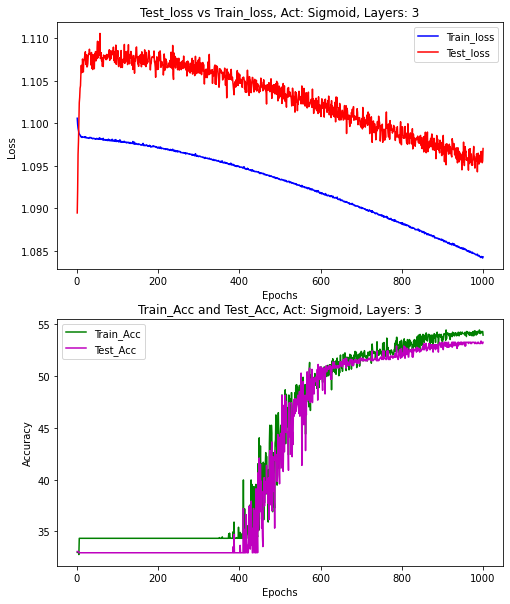

Activation Functiom:TanH
Number of hidden Layers: 3
5
Test Accuracy: 66.31%
Test Loss: 0.88
4
Test Accuracy: 66.31%
Test Loss: 0.88
3
Test Accuracy: 65.78%
Test Loss: 0.88
2
Test Accuracy: 65.95%
Test Loss: 0.88
1
Test Accuracy: 68.09%
Test Loss: 0.87


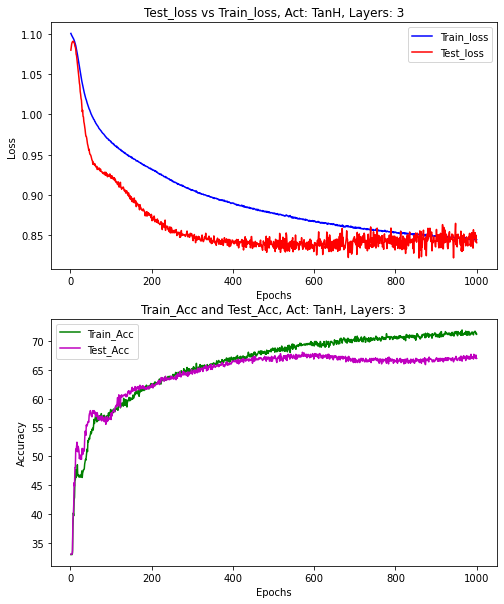

Activation Functiom:SoftPlus
Number of hidden Layers: 3
5
Test Accuracy: 65.24%
Test Loss: 0.89
4
Test Accuracy: 63.46%
Test Loss: 0.89
3
Test Accuracy: 66.84%
Test Loss: 0.88
2
Test Accuracy: 63.81%
Test Loss: 0.90
1
Test Accuracy: 63.99%
Test Loss: 0.91


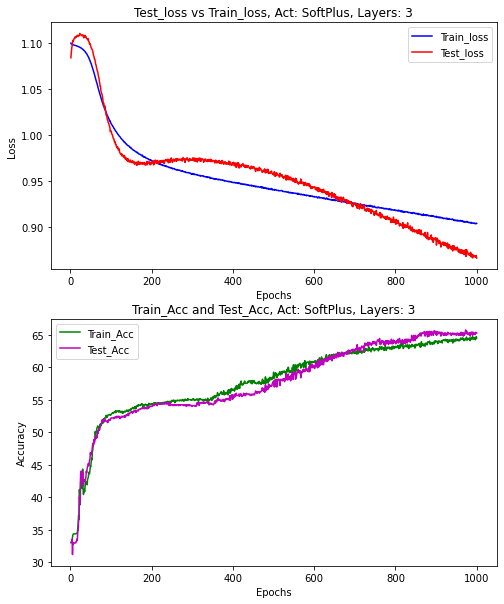

Activation Functiom:SiLU
Number of hidden Layers: 3
5
Test Accuracy: 66.67%
Test Loss: 0.88
4
Test Accuracy: 64.17%
Test Loss: 0.90
3
Test Accuracy: 66.67%
Test Loss: 0.89
2
Test Accuracy: 65.24%
Test Loss: 0.88
1
Test Accuracy: 67.02%
Test Loss: 0.88


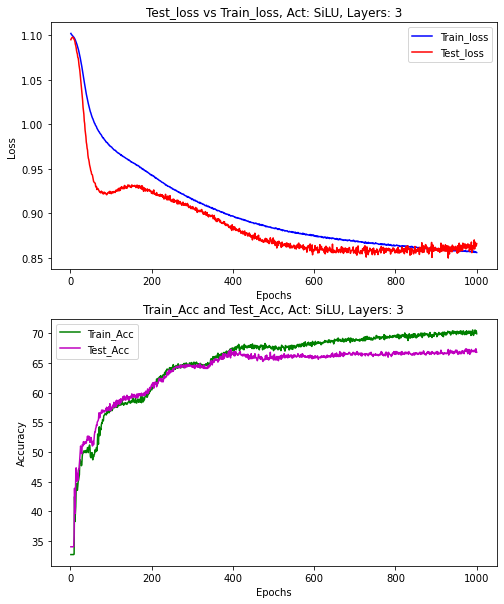

Activation Functiom:ReLU
Number of hidden Layers: 4
5
Test Accuracy: 67.20%
Test Loss: 0.88
4
Test Accuracy: 61.85%
Test Loss: 0.91
3
Test Accuracy: 67.20%
Test Loss: 0.87
2
Test Accuracy: 32.98%
Test Loss: 1.10
1
Test Accuracy: 67.56%
Test Loss: 0.88


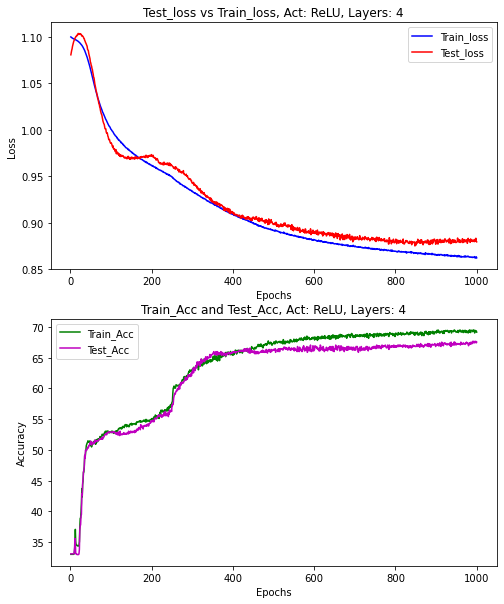

Activation Functiom:Sigmoid
Number of hidden Layers: 4
5
Test Accuracy: 32.98%
Test Loss: 1.10
4
Test Accuracy: 32.98%
Test Loss: 1.10
3
Test Accuracy: 32.98%
Test Loss: 1.10
2
Test Accuracy: 32.98%
Test Loss: 1.10
1
Test Accuracy: 32.98%
Test Loss: 1.10


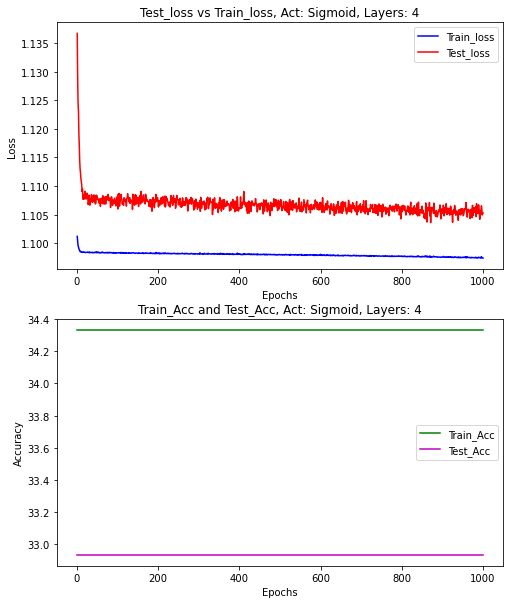

Activation Functiom:TanH
Number of hidden Layers: 4
5
Test Accuracy: 66.31%
Test Loss: 0.88
4
Test Accuracy: 67.91%
Test Loss: 0.87
3
Test Accuracy: 65.78%
Test Loss: 0.88
2
Test Accuracy: 67.91%
Test Loss: 0.88
1
Test Accuracy: 67.74%
Test Loss: 0.88


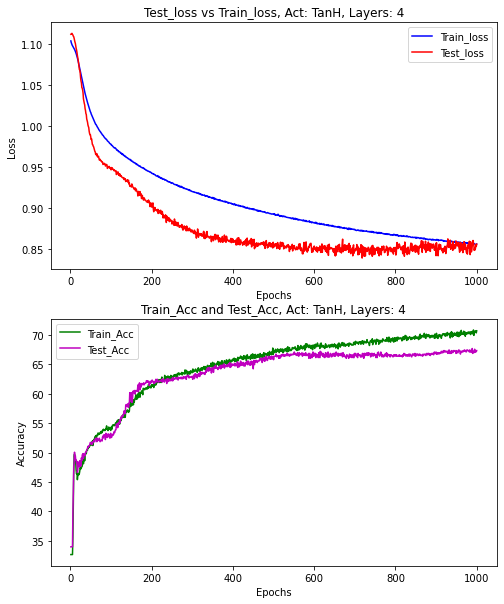

Activation Functiom:SoftPlus
Number of hidden Layers: 4
5
Test Accuracy: 64.35%
Test Loss: 0.90
4
Test Accuracy: 62.21%
Test Loss: 0.92
3
Test Accuracy: 65.78%
Test Loss: 0.90
2
Test Accuracy: 63.28%
Test Loss: 0.91
1
Test Accuracy: 62.03%
Test Loss: 0.92


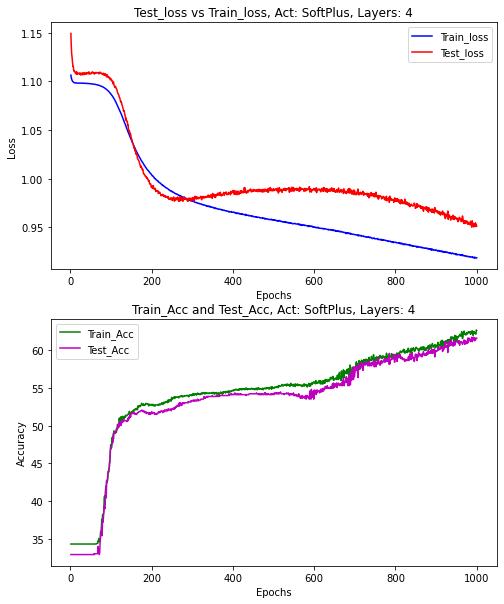

Activation Functiom:SiLU
Number of hidden Layers: 4
5
Test Accuracy: 66.84%
Test Loss: 0.88
4
Test Accuracy: 68.45%
Test Loss: 0.87
3
Test Accuracy: 64.88%
Test Loss: 0.89
2
Test Accuracy: 67.02%
Test Loss: 0.89
1
Test Accuracy: 64.71%
Test Loss: 0.88


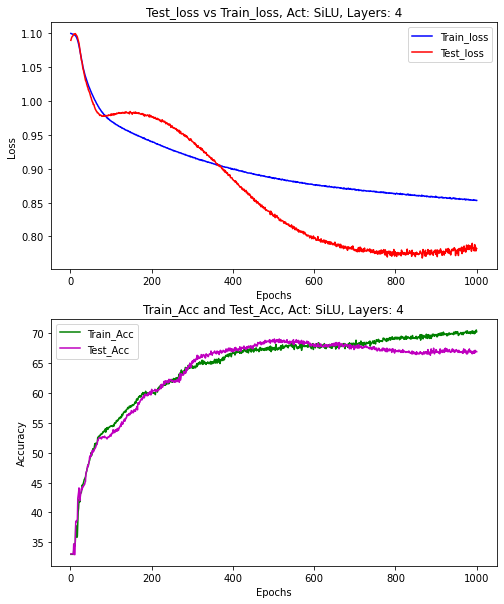

Activation Functiom:ReLU
Number of hidden Layers: 5
5
Test Accuracy: 65.60%
Test Loss: 0.89
4
Test Accuracy: 62.57%
Test Loss: 0.92
3
Test Accuracy: 63.81%
Test Loss: 0.92
2
Test Accuracy: 66.31%
Test Loss: 0.88
1
Test Accuracy: 61.68%
Test Loss: 0.92


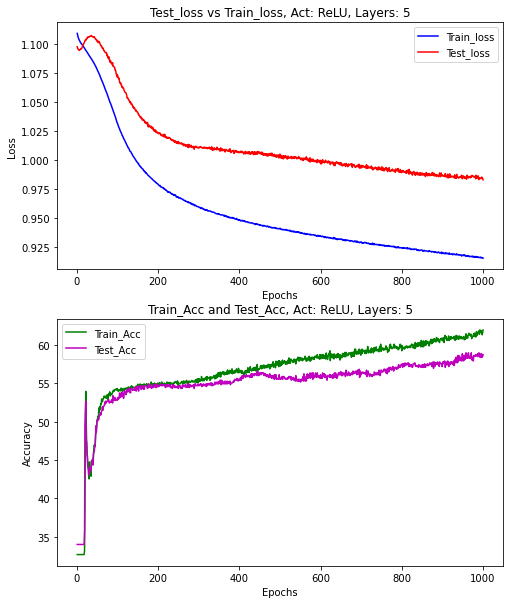

Activation Functiom:Sigmoid
Number of hidden Layers: 5
5
Test Accuracy: 32.98%
Test Loss: 1.10
4
Test Accuracy: 32.98%
Test Loss: 1.10
3
Test Accuracy: 32.98%
Test Loss: 1.10
2
Test Accuracy: 32.98%
Test Loss: 1.10
1
Test Accuracy: 32.98%
Test Loss: 1.10


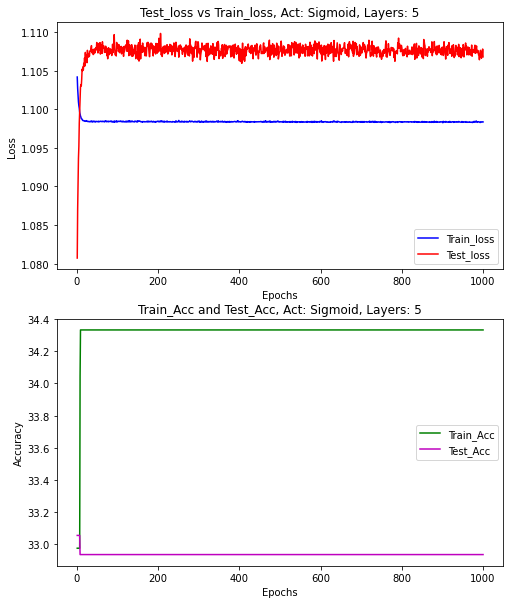

Activation Functiom:TanH
Number of hidden Layers: 5
5
Test Accuracy: 66.31%
Test Loss: 0.87
4
Test Accuracy: 67.02%
Test Loss: 0.88
3
Test Accuracy: 68.27%
Test Loss: 0.87
2
Test Accuracy: 66.13%
Test Loss: 0.88
1
Test Accuracy: 67.20%
Test Loss: 0.88


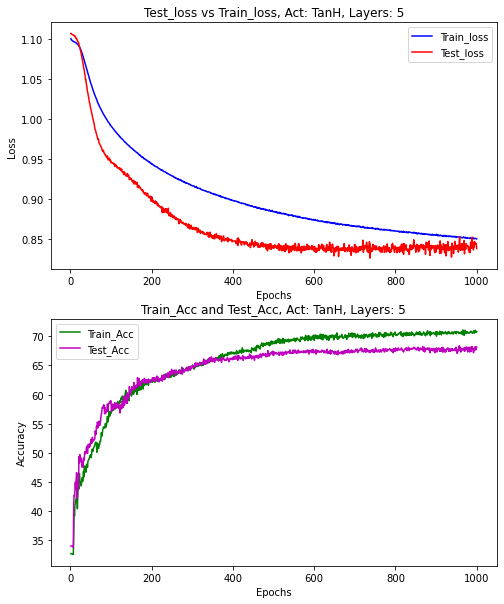

Activation Functiom:SoftPlus
Number of hidden Layers: 5
5
Test Accuracy: 60.78%
Test Loss: 0.94
4
Test Accuracy: 57.75%
Test Loss: 0.94
3
Test Accuracy: 62.03%
Test Loss: 0.92
2
Test Accuracy: 61.68%
Test Loss: 0.93
1
Test Accuracy: 58.11%
Test Loss: 0.93


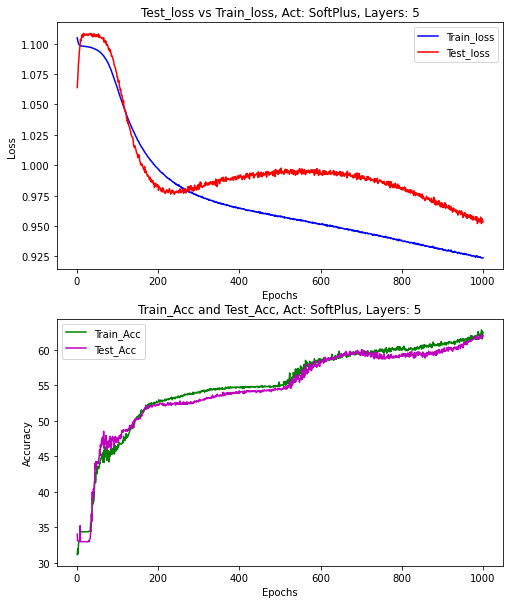

Activation Functiom:SiLU
Number of hidden Layers: 5
5
Test Accuracy: 66.49%
Test Loss: 0.89
4
Test Accuracy: 66.49%
Test Loss: 0.88
3
Test Accuracy: 66.49%
Test Loss: 0.89
2
Test Accuracy: 67.74%
Test Loss: 0.87
1
Test Accuracy: 65.60%
Test Loss: 0.89


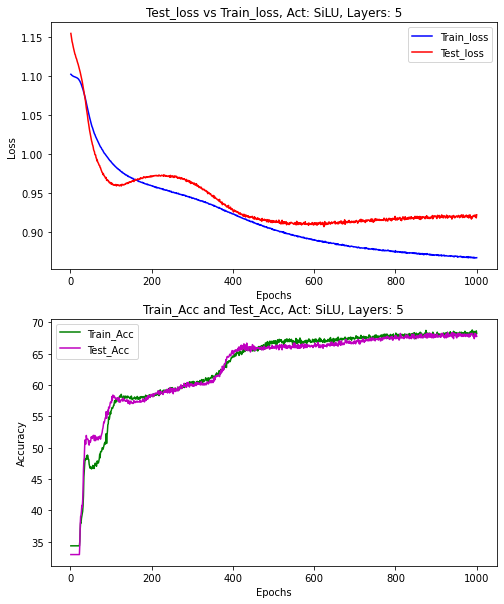

[[63.88591800356505, 63.77896613190732, 64.99108734402853, 63.52941176470589, 64.34937611408199], [64.99108734402851, 57.076648841354725, 66.45276292335116, 64.09982174688056, 65.59714795008912], [64.99108734402853, 54.18894830659538, 66.48841354723706, 64.67023172905526, 65.9536541889483], [59.35828877005347, 32.97682709447415, 67.13012477718361, 63.52941176470588, 66.38146167557932], [63.99286987522281, 32.97682709447415, 66.98752228163993, 60.07130124777184, 66.5597147950089]]
[[3.373649261088233, 0.5636858574275186, 0.7174549660427111, 1.2804481280618911, 1.2903359052302212], [1.4849672441824286, 3.868544458861089, 1.0393853645000528, 0.9599224255141723, 0.8876933759706769], [4.061668554331864, 0.3474792992801751, 1.0930274307847405, 2.504440469117072, 1.2952514883839465], [29.571542457175056, 0.0, 1.1984125714061826, 1.4193247228088666, 1.549879865902618], [2.906127252041751, 0.0, 0.7891602003985261, 2.6594983103826415, 1.1797071021585954]]


In [26]:
evals = []
std_dev = []
i = -1
for layers in range(1,6):
    i = i + 1
    evals.append([])
    std_dev.append([])
    for act in ['ReLU', 'Sigmoid', 'TanH', 'SoftPlus', 'SiLU']:
        bestAcc = -1
        print(f'Activation Functiom:{act}\nNumber of hidden Layers: {layers}')
        eval = []
        for j in range(5):
            print(5 - j)
            model, Train_loss, Train_Acc, Test_loss, Test_Acc = simulate(layers, act, train_loader, eval_loader, 1000, verbose=0)
            _, acc = test_model(model, test_loader)
            eval.append(acc)
            if(acc > bestAcc):
                best = [model, Train_loss, Train_Acc, Test_loss, Test_Acc]
        evals[i].append(sum(eval) / len(eval))
        std_dev[i].append((sum((x - eval[i]) ** 2 for x in eval) / len(eval)) ** 0.5)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
        epochs = range(1, len(best[1]) + 1)

        ax1.plot(epochs, best[1], color='b', label='Train_loss')
        ax1.plot(epochs, best[3], color='r', label='Test_loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'Test_loss vs Train_loss, Act: {act}, Layers: {layers}')
        ax1.legend()

        ax2.plot(epochs, best[2], color='g', label='Train_Acc')
        ax2.plot(epochs, best[4], color='m', label='Test_Acc')
        ax2.set_title(f'Train_Acc and Test_Acc, Act: {act}, Layers: {layers}')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.show()
print(evals)
print(std_dev)

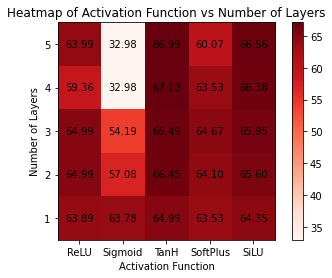

In [16]:
evals = [[63.88591800356505, 63.77896613190732, 64.99108734402853, 63.52941176470589, 64.34937611408199], 
         [64.99108734402851, 57.076648841354725, 66.45276292335116, 64.09982174688056, 65.59714795008912], 
         [64.99108734402853, 54.18894830659538, 66.48841354723706, 64.67023172905526, 65.9536541889483], 
         [59.35828877005347, 32.97682709447415, 67.13012477718361, 63.52941176470588, 66.38146167557932], 
         [63.99286987522281, 32.97682709447415, 66.98752228163993, 60.07130124777184, 66.5597147950089]]
plt.imshow(evals, cmap='Reds', origin='lower')
plt.colorbar()
x_labels = ['ReLU', 'Sigmoid', 'TanH', 'SoftPlus', 'SiLU']
y_labels = ['1', '2', '3', '4', '5']
plt.xticks(ticks=np.arange(5), labels=x_labels)
plt.yticks(ticks=np.arange(5), labels=y_labels)
plt.xlabel("Activation Function")
plt.ylabel("Number of Layers")
plt.title("Heatmap of Activation Function vs Number of Layers")

for i in range(len(evals)):
    for j in range(len(evals)):
        plt.text(j, i, f'{evals[i][j]:.2f}', ha='center', va='center', color='black')

plt.show()

In [17]:
evals = []
std_dev = []
i = -1
for layers in range(5,11):
    i = i + 1
    evals.append([])
    std_dev.append([])
    for act in ['TanH']:
        bestAcc = -1
        print(f'Activation Functiom:{act}\nNumber of hidden Layers: {layers}')
        eval = []
        for j in range(1):
            print(5 - j)
            model, Train_loss, Train_Acc, Test_loss, Test_Acc = simulate(layers, act, train_loader, eval_loader, 1500, verbose=0)
            _, acc = test_model(model, test_loader)
            eval.append(acc)
            if(acc > bestAcc):
                best = [model, Train_loss, Train_Acc, Test_loss, Test_Acc]
        evals[i].append(sum(eval) / len(eval))
        std_dev[i].append((sum((x - eval[i]) ** 2 for x in eval) / len(eval)) ** 0.5)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
        epochs = range(1, len(best[1]) + 1)

        ax1.plot(epochs, best[1], color='b', label='Train_loss')
        ax1.plot(epochs, best[3], color='r', label='Test_loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'Test_loss vs Train_loss, Act: {act}, Layers: {layers}')
        ax1.legend()

        ax2.plot(epochs, best[2], color='g', label='Train_Acc')
        ax2.plot(epochs, best[4], color='m', label='Test_Acc')
        ax2.set_title(f'Train_Acc and Test_Acc, Act: {act}, Layers: {layers}')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.show()
print(evals)
print(std_dev)

Activation Functiom:SoftPlus
Number of hidden Layers: 5
5
